# Lab 03 - Regression


## 1. Introduction to Regression

Regression is a **supervised learning task** where the goal is to **predict a continuous value** based on input features. It's used in a wide range of domains like real estate, finance, and energy systems.

### 🔍 Key Concepts:
- **Target Variable**: What we want to predict (e.g., house price).
- **Features**: Inputs used for prediction (e.g., size, income, location).
- **Regression Function**: The mathematical relationship between features and target.

### 🔄 Regression vs. Classification


| Aspect          | Regression                           | Classification                     |
|-----------------|--------------------------------------|-------------------------------------|
| Output          | Continuous (e.g., price)             | Categorical (e.g., spam/not spam)  |
| Goal            | Minimize prediction error            | Maximize correct classification     |
| Examples        | Predict temperature, sales           | Email filtering, image labeling     |
| Metrics         | MSE, MAE, R²                         | Accuracy, Precision, F1-score       |

<br>

<center>
<img src="img/Regression_vs_Classification.avif" alt="Regression vs Classification" width="50%">
</center>


### Evaluation Metrics
**Mean Absolute Error (MAE):** the average of the absolute differences $\lvert y_{\text{true}} - y_{\text{pred}} \rvert$.

**Mean Squared Error (MSE):** the average of the squared differences $(y_{\text{true}} - y_{\text{pred}})^2$.

MSE quantifies how close a predicted value is to the true value, so we'll use it to quantify how close a regression line is to a set of points.

MSE works by squaring the distance between each data point and the regression line, summing the squared values, and then dividing by the number of data points:
$$\text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2$$

The name is quite literal: take the mean of the squared errors. The squaring of errors prevents negative and positive terms from canceling out in the sum, and gives more weight to points further from the regression line, punishing outliers and larger errors are penalized more heavily.
**Root Mean Squared Error (RMSE):** the square root of **MSE**.

**RMSE** brings the error metric back to the original target units (since MSE is in squared units).


## 2. Loading and Inspecting the Dataset

In this lab, we will use the [**California Housing Dataset**](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_california_housing.html), a classic regression dataset.

### 🎯 Target Variable:
- `MedHouseValue`: Median house value in a district, expressed in $100,000.

### 📊 Features:
- `MedInc`: Median income in block group.
- `HouseAge`: Median house age in block group.
- `AveRooms`: Average number of rooms per household.
- `AveBedrms`: Average number of bedrooms per household.
- `Population`: Block group population.
- `AveOccup`: Average number of household members.
- `Latitude`: Block group latitude.
- `Longitude`: Block group longitude.

We'll begin by **loading** the dataset, **exploring** its structure, and **visualizing** the distribution of the target variable.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.datasets import fetch_california_housing
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate, validation_curve, cross_val_predict
from sklearn.linear_model import LinearRegression, SGDRegressor, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures

import warnings
from lab_utils import (
    summarize_metric,
    scoring,
    plot_residuals,
    plot_predicted_vs_actual,
)

warnings.filterwarnings("ignore")

# Set the style for plots
plt.style.use("seaborn-v0_8-whitegrid")
sns.set_palette("deep")

# Dictionary to store performance metrics
model_performances = []
random_state = 42

In [3]:
california_housing = fetch_california_housing(as_frame=True)

In [4]:
type(california_housing)

sklearn.utils._bunch.Bunch

### Bunch Object Attributes

The `bunch` object is a dictionary-like object with the following attributes:

- `data`, which is a pandas object (since `as_frame=True`). Each row corresponds to 8 feature values.

- `target` value contains average house value in units of 100,000. This is also a pandas object (since `as_frame=True`).

- `feature_names` is an array of ordered feature names used in the dataset.

- `DESCR` contains a description of the dataset.

- `frame` contains a dataframe with data and target.


In [5]:
print(california_housing.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

:Number of Instances: 20640

:Number of Attributes: 8 numeric, predictive attributes and the target

:Attribute Information:
    - MedInc        median income in block group
    - HouseAge      median house age in block group
    - AveRooms      average number of rooms per household
    - AveBedrms     average number of bedrooms per household
    - Population    block group population
    - AveOccup      average number of household members
    - Latitude      block group latitude
    - Longitude     block group longitude

:Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived from the 1990 U.S. census, using one row per ce

### Attributes and Their Description

Understanding the attributes and their descriptions is crucial for analyzing the dataset:

In [6]:
california_housing.data

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25
...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32


In [7]:
california_housing.target

0        4.526
1        3.585
2        3.521
3        3.413
4        3.422
         ...  
20635    0.781
20636    0.771
20637    0.923
20638    0.847
20639    0.894
Name: MedHouseVal, Length: 20640, dtype: float64

In [8]:
print("\nDataset Info:")
california_housing.frame.info()


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     20640 non-null  float64
 2   AveRooms     20640 non-null  float64
 3   AveBedrms    20640 non-null  float64
 4   Population   20640 non-null  float64
 5   AveOccup     20640 non-null  float64
 6   Latitude     20640 non-null  float64
 7   Longitude    20640 non-null  float64
 8   MedHouseVal  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


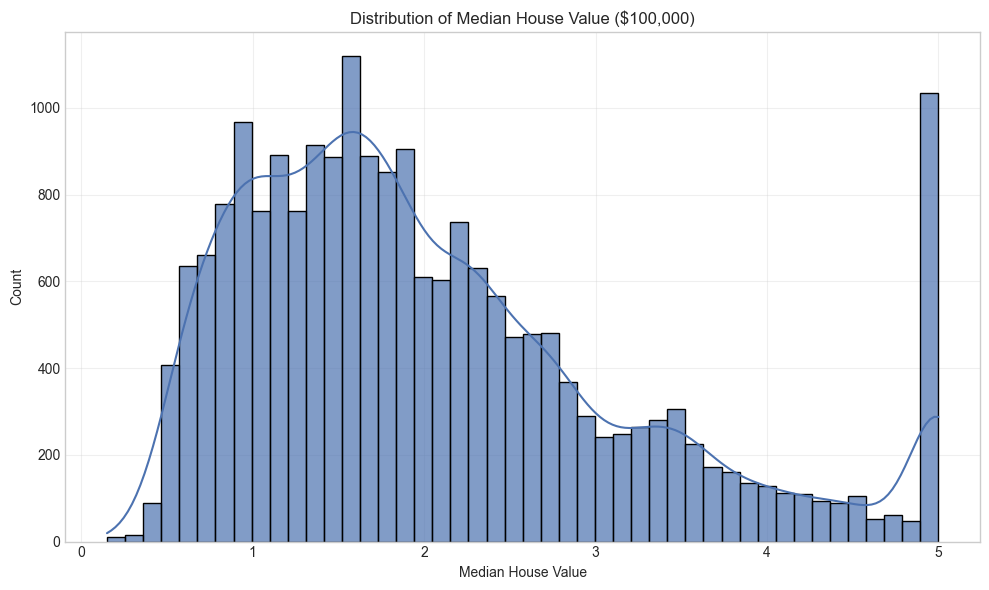

In [9]:
# Visualize the distribution of the target variable (Median House Value)
# The target variable represents the median house value for California districts, expressed in $100,000.

plt.figure(figsize=(10, 6))
sns.histplot(california_housing.target, kde=True, alpha=0.7)
plt.title('Distribution of Median House Value ($100,000)')
plt.xlabel('Median House Value')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

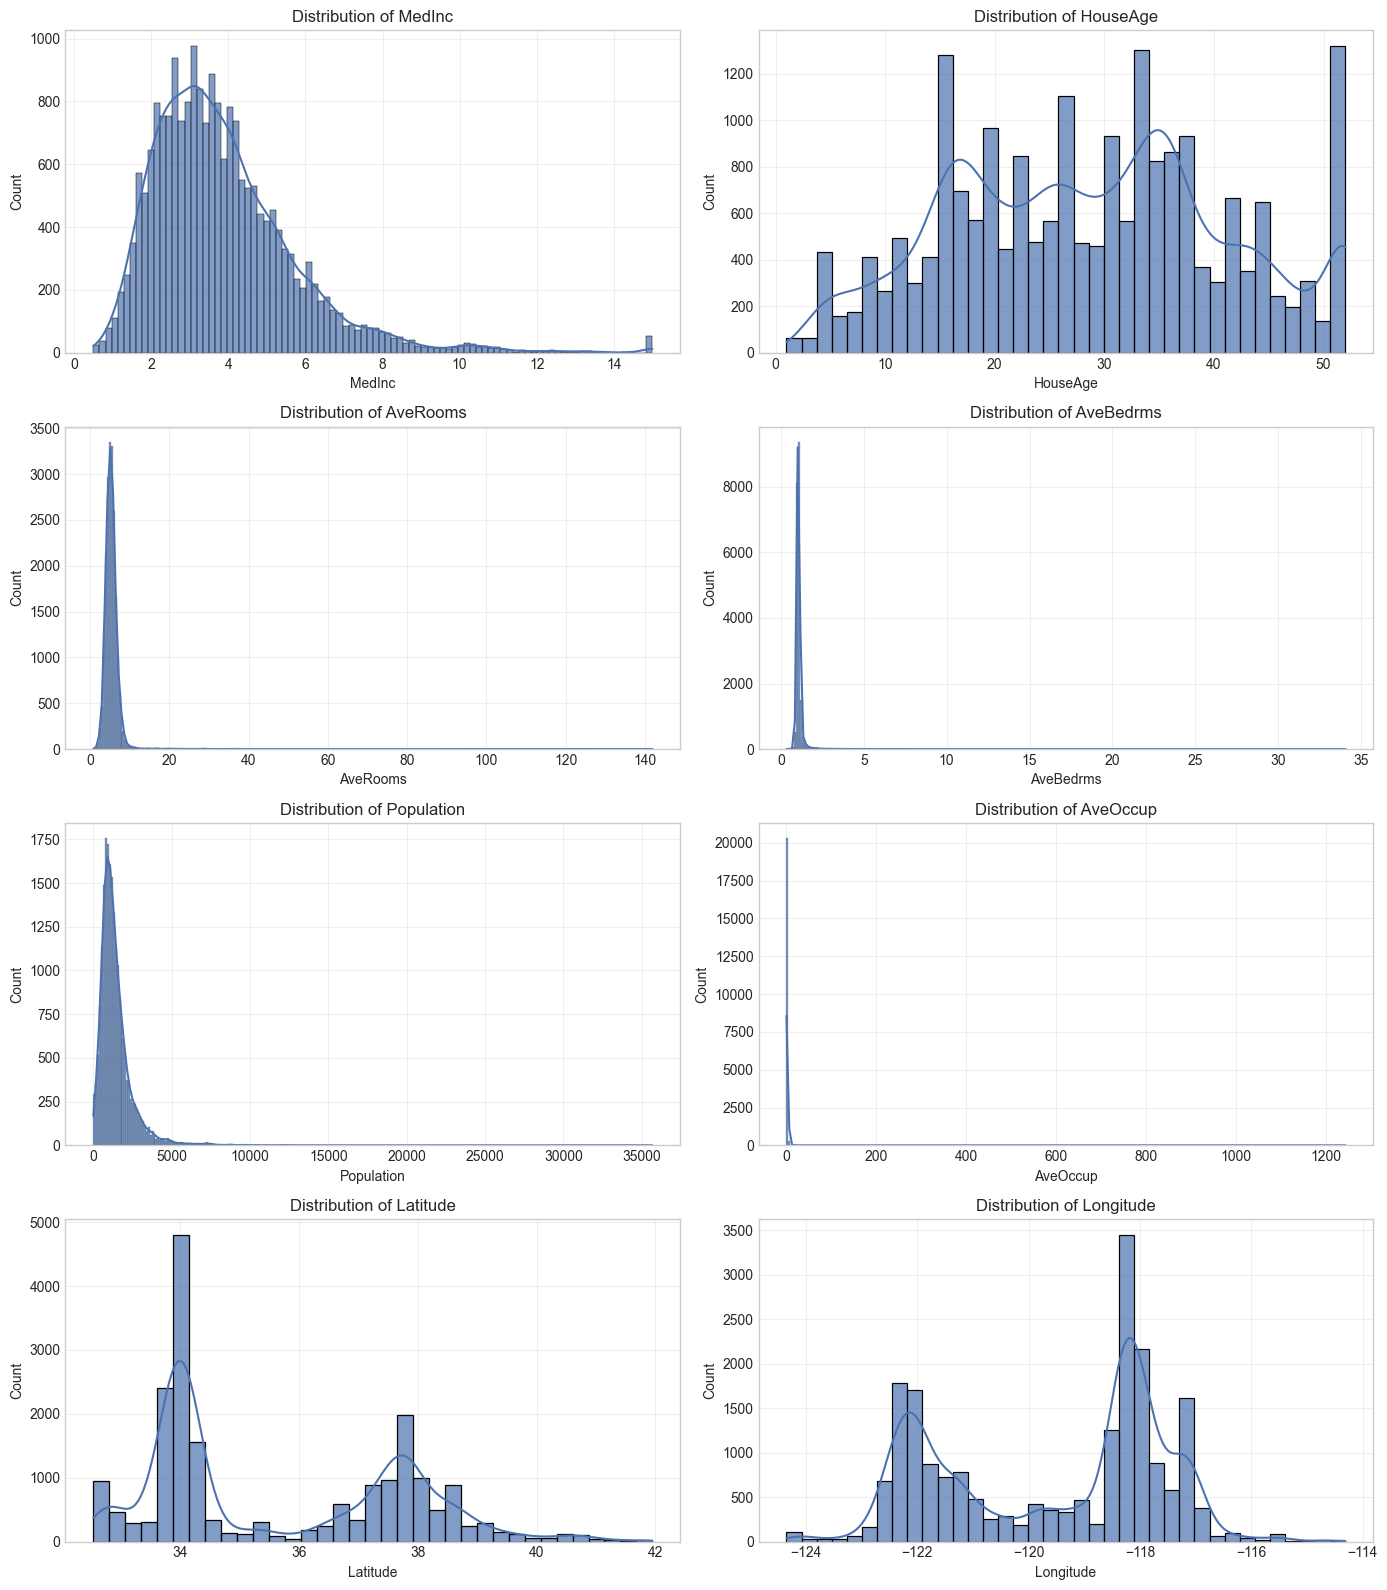

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

features = california_housing.data.columns
num_features = len(features)

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(14, 16))
axes = axes.flatten()

for i, feature in enumerate(features):
    sns.histplot(california_housing.data[feature], kde=True, alpha=0.7, ax=axes[i])
    axes[i].set_title(f'Distribution of {feature}')
    axes[i].set_xlabel(feature)
    axes[i].grid(True, alpha=0.3)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [11]:
print("Dataset Description:")
california_housing.frame.describe(percentiles=[0.25, 0.5, 0.75, 0.99])

Dataset Description:


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
99%,10.596540,52.000000,10.357033,2.127541,5805.830000,5.394812,40.626100,-116.290000,5.000010
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


## 3. Train/Validation/Test Split

To evaluate our model fairly, we split the data into:

- **Training set**: for fitting the model
- **Test set**: for final performance assessment

<center>
<img src="img/train_val_test_split.png" alt="Regression vs Classification" width="50%">
</center>

In [12]:
features, labels = fetch_california_housing(as_frame=True, return_X_y=True)

X_train, X_test, y_train, y_test = train_test_split(
    features, labels, test_size=0.2, random_state=random_state
)

print(f"Train samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")

Train samples: 16512
Test samples: 4128


## 4. Feature Scaling

Feature scaling is a **preprocessing step** that adjusts the range or distribution of features. It ensures that no single feature dominates others due to its scale — especially important when features have different units (like income in dollars vs. number of rooms).


### 🚀 Why Scale Features?

1. **Balances Feature Influence**  
   Without scaling, features with larger values can overshadow others in model training.

2. **Improves Model Accuracy**  
   Algorithms like KNN or SVR depend on distances — scaling ensures those distances are meaningful.

### 📐 Two Common Scaling Methods

#### 1. `StandardScaler`  
Transforms features to **zero mean** and **unit variance** (usually used for *distributions* that already resemble a **Gaussian distribution**):  
$$
z = \frac{x - \mu}{\sigma}
$$  

#### 2. `MinMaxScaler`  
Rescales data to a **fixed range**, usually [0, 1]:  
$$
x' = \frac{x - \text{min}(x)}{\text{max}(x) - \text{min}(x)}
$$  


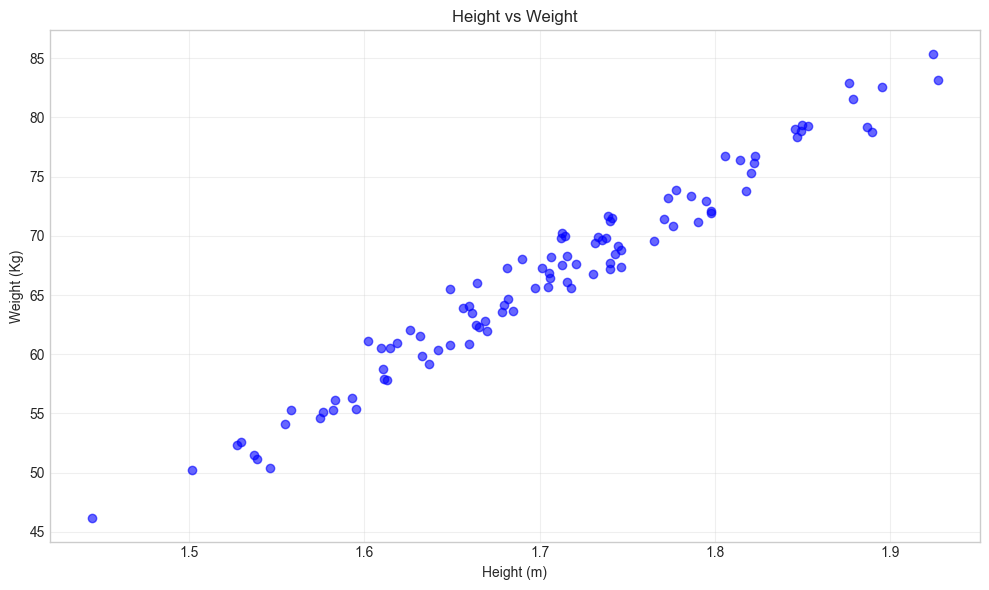

In [13]:
# Generate height and weight data
np.random.seed(0)
heights = np.random.normal(1.70, 0.1, 100).reshape(-1, 1)
weights = 50 + (heights - 1.50) * 80 + np.random.normal(0, 1.5, heights.shape[0]).reshape(-1, 1)

# Plot original data
plt.figure(figsize=(10, 6))
plt.scatter(heights, weights, color='blue', alpha=0.6)
plt.title('Height vs Weight')
plt.xlabel('Height (m)')
plt.ylabel('Weight (Kg)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

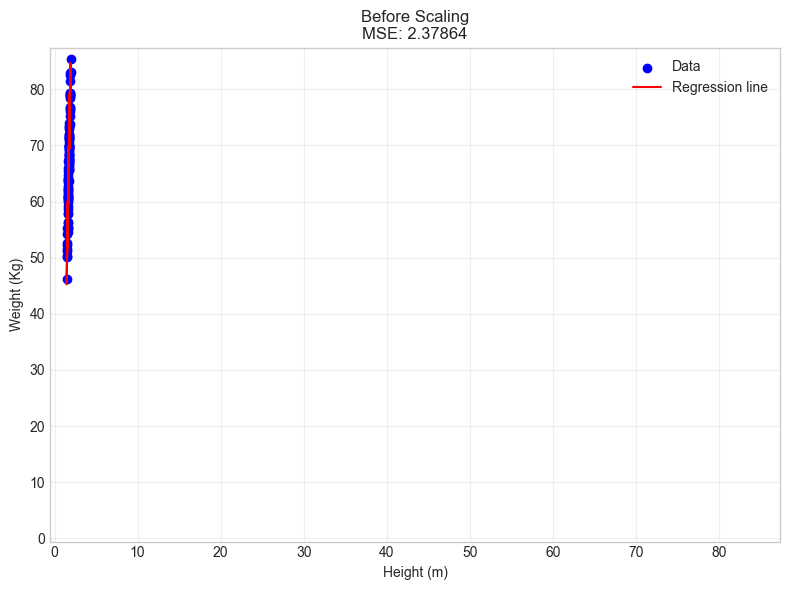

In [14]:
# Fit linear regression on raw data
model_unscaled = LinearRegression()
model_unscaled.fit(heights, weights)
preds_unscaled = model_unscaled.predict(heights)
mse_unscaled = mean_squared_error(weights, preds_unscaled)

min_val = min(heights.min(), weights.min())-2
max_val = max(heights.max(), weights.max())+2

plt.figure(figsize=(8, 6))
ax = plt.gca()  # Ottieni l'oggetto Axes corrente
plt.scatter(heights, weights, color='blue', label='Data')
plt.plot(heights, preds_unscaled, color='red', label='Regression line')
plt.title(f"Before Scaling\nMSE: {mse_unscaled:.5f}")
plt.xlabel("Height (m)")
plt.ylabel("Weight (Kg)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
ax.set_xlim(min_val, max_val)
ax.set_ylim(min_val, max_val)
plt.show()

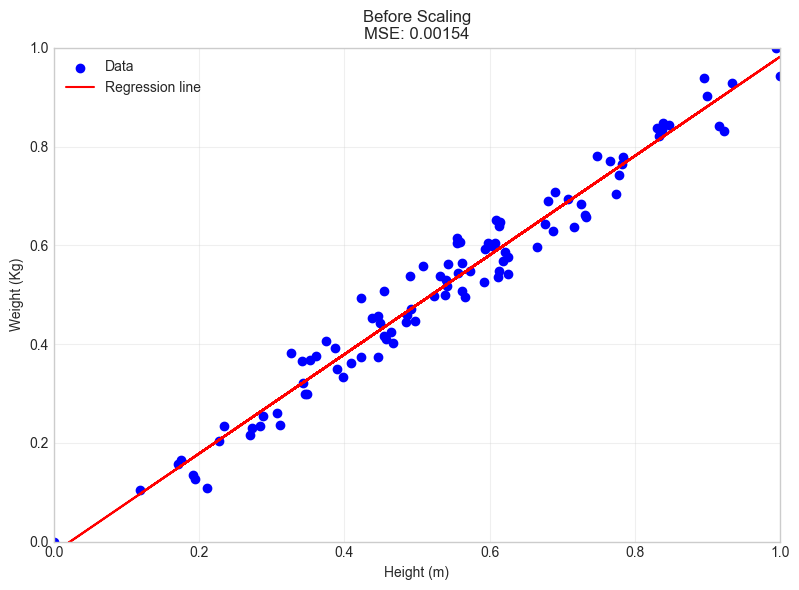

In [15]:
scaler = MinMaxScaler()
heights_scaled = scaler.fit_transform(heights)
weights_scaled = scaler.fit_transform(weights)

model_scaled = LinearRegression()
model_scaled.fit(heights_scaled, weights_scaled)
preds_scaled = model_scaled.predict(heights_scaled)
mse_scaled = mean_squared_error(weights_scaled, preds_scaled)

min_val = min(heights_scaled.min(), weights_scaled.min())
max_val = max(heights_scaled.max(), weights_scaled.max())

plt.figure(figsize=(8, 6))
ax = plt.gca()  # Ottieni l'oggetto Axes corrente
plt.scatter(heights_scaled, weights_scaled, color='blue', label='Data')
plt.plot(heights_scaled, preds_scaled, color='red', label='Regression line')
plt.title(f"Before Scaling\nMSE: {mse_scaled:.5f}")
plt.xlabel("Height (m)")
plt.ylabel("Weight (Kg)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
ax.set_xlim(min_val, max_val)
ax.set_ylim(min_val, max_val)
plt.show()

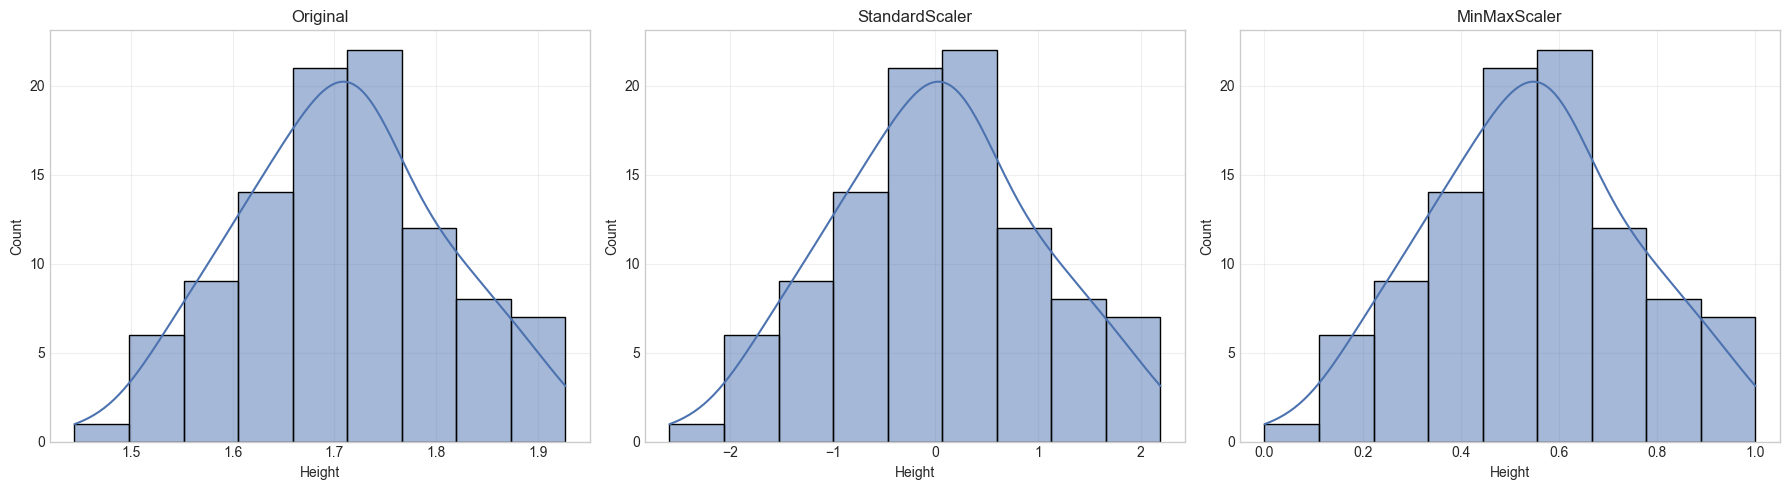

In [16]:
scaler_standard = StandardScaler()
height_standard = scaler_standard.fit_transform(heights)

scaler_minmax = MinMaxScaler()
height_minmax = scaler_minmax.fit_transform(heights)

# Plot the original and scaled data
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

sns.histplot(heights.flatten(), kde=True, ax=ax1)
ax1.set_title('Original')

sns.histplot(height_standard.flatten(), kde=True, ax=ax2)
ax2.set_title('StandardScaler')

sns.histplot(height_minmax.flatten(), kde=True, ax=ax3)
ax3.set_title('MinMaxScaler')

for ax in (ax1, ax2, ax3):
    ax.grid(True, alpha=0.3)
    ax.set_xlabel("Height")

plt.tight_layout()
plt.show()

## 5. Model Training and Error Evaluation


### 5.1 Linear Regression

Linear regression is a supervised algorithm that learns to model a dependent variable, $y$, as a function of some independent variables (aka "features"), $x_i$, by finding a line (or surface) that best "fits" the data. In general, we assume $y$ to be some number and each $x_i$ can be basically anything. For example: predicting the price of a house using the number of rooms in that house ($y$: price,$x_1$ : number of rooms) or predicting weight from height and age ($y$: weight, $x_1$: height, $x_2$: age).

In general, the equation for linear regression is:
$$y = \beta_0 + \beta_1x_1 + \beta_2x_2 + ... + \beta_px_p + \epsilon$$

where:

- $y$: the dependent variable; the thing we are trying to predict.
- $x_i$: the independent variables: the features our model uses to model y.
- $\beta_i$: the coefficients (aka "weights") of our regression model. These are the foundations of our model. They are what our model "learns" during optimization.
- $\epsilon$: the irreducible error in our model. A term that collects together all the unmodeled parts of our data.

Fitting a linear regression model is all about finding the set of cofficients that best model $y$ as a function of our features. We may never know the true parameters for our model, but we can estimate them (more on this later). Once we've estimated these coefficients, $\hat \beta_i$, we predict future values, $\hat y$, as:

$$\hat y = \hat \beta_0 + \hat \beta_1x_1 + \hat \beta_2x_2 + ... + \hat \beta_px_p$$

So predicting future values (often called inference), is as simple as plugging the values of our features $x_i$ into our equation!

<center>
<img src="img/linear_regression.png" alt="Regression vs Classification" width="50%">
</center>

#### Linear Regression

Instead of using iterative methods like Gradient Descent, we can solve for $ \boldsymbol{\theta} $ directly using the **Normal Equation**:

$$
\boldsymbol{\theta} = (\mathbf{X}^\top \mathbf{X})^{-1} \mathbf{X}^\top \mathbf{y}
$$

This formula gives the **closed-form solution** that minimizes the Mean Squared Error (MSE):

$$
\text{MSE} = \frac{1}{n} \| \mathbf{X} \boldsymbol{\theta} - \mathbf{y} \|^2
$$

The pipeline is set up with two key stages:

- **Feature Scaling**: To scale the features appropriately.
- **Linear Regression**: To perform regression on the transformed feature matrix.

Throughout this notebook, we will follow a consistent pattern for each estimator:

- **Pipeline**: Combines data preprocessing and modeling steps.
- **cross_validate**: Trains the model using `ShuffleSplit` cross-validation with `neg_mean_absolute_error` as the scoring metric.
- **Error Reporting**: Converts scores to errors and reports mean absolute errors on the development set.


In [17]:
lin_reg_pipeline = Pipeline(
    [("feature_scaling", StandardScaler()), ("lin_reg", LinearRegression())]
)

lin_reg_cv_results = cross_validate(
    lin_reg_pipeline,
    X_train,
    y_train,
    scoring=scoring,
    return_train_score=True,
    return_estimator=True,
    n_jobs=-1,
    cv=5,
)

lin_reg_res = summarize_metric("Linear Regression", lin_reg_cv_results)
model_performances.append(lin_reg_res)

MAE on train set: 0.529
MAE on validation set: 0.529
MSE on train set: 0.518
MSE on validation set: 0.519


### 5.2 Polynomial Regression

Polynomial regression is simply a linear regression on expanded features that include polynomial terms (e.g. $x^2$,$x^3$, etc.). In other words, we add new features like the square and cross-products of the original features. This allows fitting a curved (non-linear) relationship while still using a linear model under the hood.

For example, with `degree=2` we include all squared terms and interactions. We can implement this conveniently with scikit-learn’s `PolynomialFeatures` plus a `LinearRegression`. The model can capture quadratic curvature, but adding high-degree polynomials risks overfitting, so we keep degree small (e.g. 2).

In this segment, we will explore polynomial regression by training a model with a degree of 2. Additionally, we will use the `validation_curve` to determine the optimal degree for polynomial models.

The `PolynomialFeatures` function is employed to transform the features to the specified degree (in this case, 2). After transforming the features, we apply feature scaling before training the regression model.

<center>
<img src="img/polynomial_regression.jpg" alt="Regression vs Classification" width="50%">
</center>

In [18]:
poly_reg_pipeline = Pipeline(
    [
        ("poly", PolynomialFeatures(degree=2)),
        ("feature_scaling", StandardScaler()),
        ("lin_reg", LinearRegression()),
    ]
)

poly_reg_cv_results = cross_validate(
    poly_reg_pipeline,
    X_train,
    y_train,
    scoring=scoring,
    return_train_score=True,
    return_estimator=True,
    n_jobs=-1,
    cv=5,
)

poly_res = summarize_metric("Polynomial Regression", poly_reg_cv_results)

model_performances.append(poly_res)

MAE on train set: 0.460
MAE on validation set: 0.497
MSE on train set: 0.418
MSE on validation set: 10.448


#### Choosing the right Polynominal Degree

To determine the most suitable polynomial degree for our regression problem, we will employ the `validation_curve`. This technique acts as a manual hyperparameter tuning method.

We will specify a list of polynomial degree values to explore, which will be passed as a parameter to the `validation_curve`. This allows us to identify the optimal degree that minimizes the error and improves the model's performance.

<center>
<img src="img/overfitting.png" alt="Regression vs Classification" width="50%">
</center>

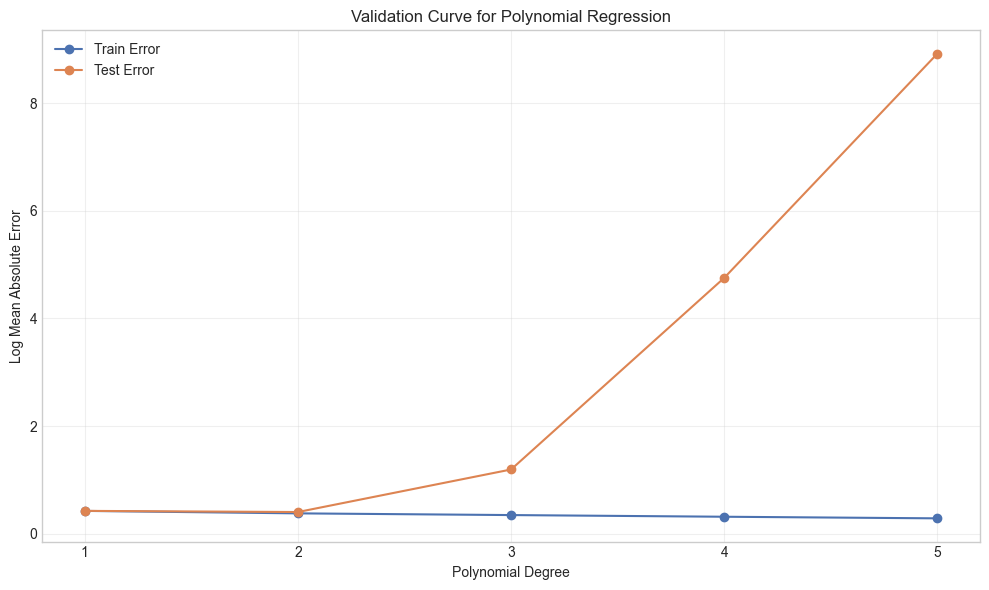

In [19]:
degree = [1, 2, 3, 4, 5]
train_scores, test_scores = validation_curve(
    poly_reg_pipeline,
    X_train,
    y_train,
    param_name="poly__degree",
    param_range=degree,
    scoring="neg_mean_absolute_error",
    n_jobs=-1,
)

train_errors, test_errors = -train_scores, -test_scores

# transform the error in logarithmic scale
train_errors = np.log(train_errors+1)
test_errors = np.log(test_errors+1)
plt.figure(figsize=(10, 6))
plt.plot(degree, train_errors.mean(axis=1), label="Train Error", marker="o")
plt.plot(degree, test_errors.mean(axis=1), label="Test Error", marker="o")
plt.title("Validation Curve for Polynomial Regression")
plt.xlabel("Polynomial Degree")
plt.ylabel("Log Mean Absolute Error")
plt.xticks(degree)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

#### Selecting the optimal Polynomial Degree

To identify the most effective polynomial degree, we focus on the degree that results in the lowest mean absolute error. In our analysis, a degree of 2 emerges as the optimal choice, as it yields the minimum mean absolute error. This degree will be selected for our polynomial regression model, ensuring a balance between model complexity and predictive accuracy.


### 5.3 Ridge Regression

**Ridge Regression** is a type of linear regression that adds a **penalty** to the model for having large coefficients. It's used when we want to prevent **overfitting**, especially when we have:

- Many features,
- Multicollinearity (features that are correlated),
- Small datasets with noisy data.

In standard linear regression, we minimize the **Mean Squared Error (MSE)**:

$$
\text{MSE} = \frac{1}{n} \sum_{i=1}^n (y_i - \hat{y}_i)^2
$$

In **Ridge Regression**, we add a penalty term to the cost function:

$$
\text{Loss} = \text{MSE} + \alpha \sum_{j=1}^p \theta_j^2
$$

Where:
- $\theta_j$: the model's coefficients,
- $\alpha \geq 0$: the **regularization strength**,
- A larger $\alpha$ shrinks the coefficients more (stronger regularization).
<br>
<center>
<img src="img/ridge.png" alt="Regression vs Classification" width="25%">
</center>

In [20]:
ridge_reg_pipeline = Pipeline(
    [
        ("poly", PolynomialFeatures(degree=2, interaction_only=True)),
        ("feature_scaling", StandardScaler()),
        ("ridge", Ridge(alpha=0.5)),
    ]
)
ridge_reg_cv_results = cross_validate(
    ridge_reg_pipeline,
    X_train,
    y_train,
    scoring=scoring,
    return_train_score=True,
    return_estimator=True,
    n_jobs=-1,
    cv=5,
)

ridge_res = summarize_metric("Rige Regression", ridge_reg_cv_results)

MAE on train set: 0.487
MAE on validation set: 0.497
MSE on train set: 0.453
MSE on validation set: 0.790


#### Ridge Hyperparameter tuning with `GridSeachCV`

To identify the optimal regularization strength for Ridge regression, we can use `GridSearchCV` for hyperparameter tuning.


In [21]:
ridge_grid_pipeline = Pipeline(
    [
        ("poly", PolynomialFeatures(degree=2, interaction_only=True)),
        ("feature_scaling", StandardScaler()),
        ("ridge", Ridge()),
    ]
)

param_grid = {"poly__degree": (1, 2, 3), "ridge__alpha": np.logspace(-4, 0, num=20)}

ridge_grid_search = GridSearchCV(
    ridge_grid_pipeline,
    param_grid=param_grid,
    n_jobs=-1,
    scoring=scoring,
    return_train_score=True,
    cv=5,
    refit="mse",
)

ridge_grid_search.fit(X_train, y_train)

,estimator,"Pipeline(step...e', Ridge())])"
,param_grid,"{'poly__degree': (1, ...), 'ridge__alpha': array([1.0000...00000000e+00])}"
,scoring,"{'mae': 'neg_mean_absolute_error', 'mse': 'neg_mean_squared_error'}"
,n_jobs,-1
,refit,'mse'
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,True
,degree,1


`ridge_grid_search.best_index_` gives us the index of the best parameter in the list


In [22]:
ridge_reg_res = summarize_metric("Ridge Regression", ridge_grid_search, type="grid")
model_performances.append(ridge_reg_res)

Best MAE on train set: 0.529
Best MAE on validation set: 0.529
Best MSE on train set: 0.518
Best MSE on validation set: 0.519


### 5.4 Lasso Regression


**Lasso Regression** (Least Absolute Shrinkage and Selection Operator) is another type of linear regression with **regularization**. Like Ridge, it helps reduce **overfitting**, but it has an extra benefit: it can also be used for **feature selection**.

Lasso modifies the linear regression cost function by adding an L1 penalty (the sum of the absolute values of the coefficients):

$$
\text{Loss} = \text{MSE} + \alpha \sum_{j=1}^p |\theta_j|
$$

Where:
- $\theta_j$: the model’s coefficients,
- $\alpha \geq 0$: the regularization strength,
- The L1 penalty can **shrink some coefficients exactly to zero**.

In [23]:
lasso_reg_pipeline = Pipeline(
    [
        ("poly", PolynomialFeatures(degree=2, interaction_only=True)),
        ("feature_scaling", StandardScaler()),
        ("lasso", Lasso(alpha=0.01)),
    ]
)
lasso_reg_cv_results = cross_validate(
    lasso_reg_pipeline,
    X_train,
    y_train,
    scoring=scoring,
    return_train_score=True,
    return_estimator=True,
    n_jobs=-1,
    cv=5,
)

ridge_res = summarize_metric("Lasso Regression", lasso_reg_cv_results)

MAE on train set: 0.529
MAE on validation set: 0.530
MSE on train set: 0.519
MSE on validation set: 0.523


#### Lasso Hyperparameter tuning with `GridSeachCV`


In [24]:
lasso_grid_pipeline = Pipeline(
    [
        ("poly", PolynomialFeatures(interaction_only=True)),
        ("feature_scaling", StandardScaler()),
        ("lasso", Lasso()),
    ]
)

param_grid = {"poly__degree": (1, 2, 3), "lasso__alpha": np.logspace(-4, 0, num=20)}

lasso_grid_search = GridSearchCV(
    lasso_grid_pipeline,
    param_grid=param_grid,
    n_jobs=-1,
    scoring=scoring,
    return_train_score=True,
    cv=5,
    refit="mse",
)

lasso_grid_search.fit(X_train, y_train)

,estimator,"Pipeline(step...o', Lasso())])"
,param_grid,"{'lasso__alpha': array([1.0000...00000000e+00]), 'poly__degree': (1, ...)}"
,scoring,"{'mae': 'neg_mean_absolute_error', 'mse': 'neg_mean_squared_error'}"
,n_jobs,-1
,refit,'mse'
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,True
,degree,1


In [25]:
lasso_reg_res = summarize_metric("Lasso Regression", lasso_grid_search, type="grid")
model_performances.append(lasso_reg_res)

Best MAE on train set: 0.529
Best MAE on validation set: 0.529
Best MSE on train set: 0.518
Best MSE on validation set: 0.519


In [26]:
print("The best parameter value is:", lasso_grid_search.best_params_)

The best parameter value is: {'lasso__alpha': np.float64(0.00042813323987193956), 'poly__degree': 1}


### 5.4 Decision Tree Regressor


A decision tree for regression splits the data recursively by feature thresholds, partitioning the input space into regions and predicting the mean target in each leaf.

This model can capture highly non-linear relationships without any feature engineering: it simply finds the best splits to reduce variance. However, a deep tree can overfit the data (learning noise) easily. For example, a depth-5 tree in a toy regression may “memorize” noise, while a shallow tree (depth=2) captures only main trends.

In practice we control overfitting by limiting tree depth or using pruning. Decision trees naturally give feature importances (via impurity decrease), though they can be unstable.

<br>
<center>
<img src="img/tree_regression.png" alt="Regression vs Classification" width="50%">
</center>

In [27]:
tree_reg_pipeline = Pipeline(
    [
        ("tree_reg", DecisionTreeRegressor(max_depth=5, random_state=random_state)),
    ]
)

tree_reg_pipeline_cv_results = cross_validate(
    tree_reg_pipeline,
    X_train,
    y_train,
    scoring=scoring,
    return_train_score=True,
    return_estimator=True,
    n_jobs=-1,
    cv=5,
)

tree_reg_res = summarize_metric("Tree Regression", tree_reg_pipeline_cv_results)
model_performances.append(tree_reg_res)

MAE on train set: 0.506
MAE on validation set: 0.519
MSE on train set: 0.478
MSE on validation set: 0.508


### 5.5 Random Forest Regressor


Random Forest is an ensemble of decision trees. It builds many trees on bootstrapped samples and averages their predictions. This reduces variance (overfitting) compared to a single tree, leading to better generalization.

Each tree is still non-linear, but averaging them smooths out the noise. Random forests can capture complex patterns and are often very accurate. They also provide feature importance measures (averaging the trees’ importances). However, they lose interpretability of single trees.

<br>
<center>
<img src="img/forest_regression.png" alt="Regression vs Classification" width="50%">
</center>

In [28]:
forest_reg_pipeline = Pipeline(
    [
        (
            "forest_reg",
            RandomForestRegressor(n_estimators=100, random_state=random_state),
        ),
    ]
)

forest_reg_pipeline_cv_results = cross_validate(
    forest_reg_pipeline,
    X_train,
    y_train,
    scoring=scoring,
    return_train_score=True,
    return_estimator=True,
    n_jobs=-1,
    cv=5,
)

forest_reg_res = summarize_metric("Random Forest Regression", forest_reg_pipeline_cv_results)
model_performances.append(forest_reg_res)

MAE on train set: 0.124
MAE on validation set: 0.334
MSE on train set: 0.037
MSE on validation set: 0.261


### 5.6 Support Vector Regressor (SVR)


SVR adapts the idea of Support Vector Machines to regression. It tries to fit a function that deviates from the data by no more than a small margin $\varepsilon$, focusing on points outside this margin.

By using kernel functions (e.g. radial basis function), SVR can model non-linear relationships. It is robust and can handle outliers (since small errors within $\varepsilon$ are ignored).

<br>
<center>
<img src="img/svr.png" alt="Regression vs Classification" width="50%">
</center>

In [29]:
svr_reg_pipeline = Pipeline(
    [
        ("feature_scaling", StandardScaler()),
        ("svr_reg", SVR(kernel="rbf", C=10, epsilon=0.1)),
    ]
)

svr_reg_pipeline_cv_results = cross_validate(
    svr_reg_pipeline,
    X_train,
    y_train,
    scoring=scoring,
    return_train_score=True,
    return_estimator=True,
    n_jobs=-1,
    cv=5,
)

svr_reg_res = summarize_metric("SVR Regression", svr_reg_pipeline_cv_results)
model_performances.append(svr_reg_res)

MAE on train set: 0.355
MAE on validation set: 0.375
MSE on train set: 0.295
MSE on validation set: 0.321


## 6. Error Analysis


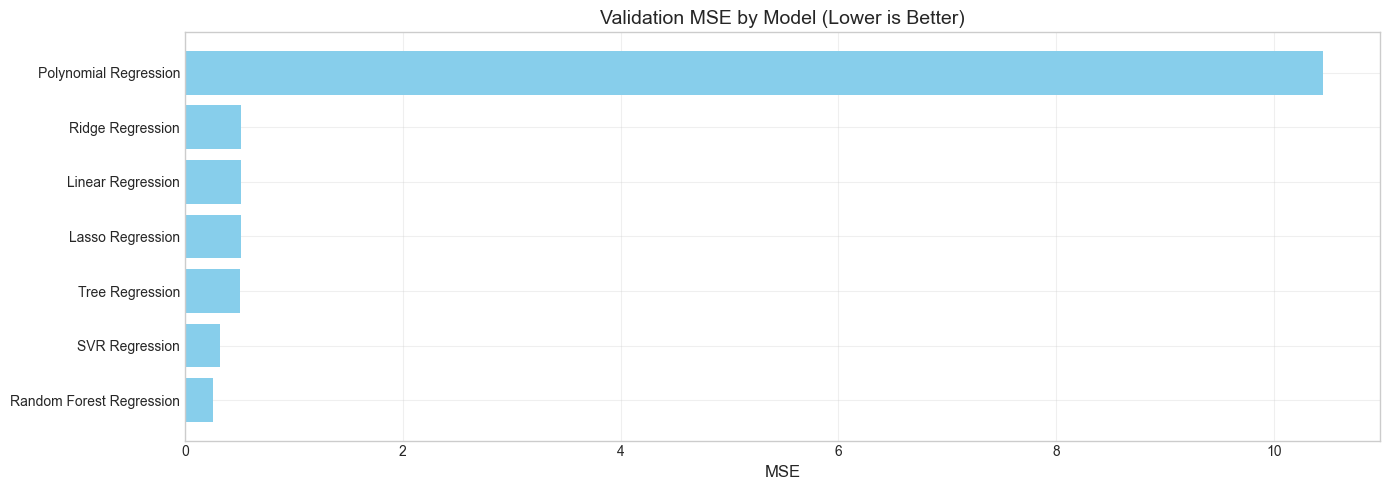

In [30]:
performance_df = pd.DataFrame(model_performances).sort_values(by="val_MSE")

# Plot comparison of models
plt.figure(figsize=(14, 5))

plt.barh(performance_df["model_name"], performance_df["val_MSE"], color="skyblue")
plt.title("Validation MSE by Model (Lower is Better)", fontsize=14)
plt.xlabel("MSE", fontsize=12)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [31]:
best_model_name = performance_df.iloc[0]["model_name"]
print(f"\nBest performing model based on validation MSE score: {best_model_name}")


Best performing model based on validation MSE score: Random Forest Regression
